# Setup

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib as mpl
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd
import os
import random
import re
import cv2
import gc
import logging
from scipy.spatial import cKDTree

SkLearn libraries:

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE

TensorFlow libraries:

In [3]:
import tensorflow as tf
from tensorflow import keras as tfk
import keras
!pip install -q keras_cv
import keras_cv as kcv
from keras_cv.layers import RandomApply
print(f"TensorFlow version {tf.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.3 MB/s eta 0:00:00
TensorFlow version 2.17.1


Some settings:

In [4]:
SEED = 42

# Set seed for random
random.seed(SEED)

# Set seed for numpy
np.random.seed(SEED) # NumPy

# Set seed for TensorFlow
tf.random.set_seed(SEED)
# TensorFlow automatically handles GPU seed as well, no need for manual seed setting

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

tf.autograph.set_verbosity(0)
tf.compat.v1.set_random_seed(SEED)

Some viz settings:

In [5]:
plt.tight_layout();
pd.set_option('display.max_rows', None);
# pd.reset_option('display.max_rows')

<Figure size 640x480 with 0 Axes>

# Data Handling

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Import

In [7]:
SHARED_DIR = "/content/gdrive/MyDrive/AN2DL_hw_1"
MY_DIR = "/content/gdrive/MyDrive/blood_dir"

Import the public set:

In [8]:
with np.load(SHARED_DIR+"/training_set.npz", allow_pickle=True) as data:
    images = data['images']
    labels = data['labels'].reshape(-1)
num_classes = len(np.unique(labels))
images.shape, labels.shape, num_classes

((13759, 96, 96, 3), (13759,), 8)

## Data Cleaning

Remove duplicates:

In [9]:
images, unique_idxs = np.unique(images, axis=0, return_index=True)
labels = labels[unique_idxs]
images.shape, labels.shape

((11953, 96, 96, 3), (11953,))

Remove anomalies:

In [10]:
shrek = images[58]
rick = images[1008]
# plt.imshow(shrek)
# plt.imshow(rick)

In [11]:
shrek_idxs = np.all(images == shrek, axis=(1, 2, 3))
rick_idxs = np.all(images == rick, axis=(1, 2, 3))
print(f"{shrek_idxs.sum()} shreks")
print(f"{rick_idxs.sum()} rick")
# TODO for now let's keep Rick

1 shreks
1 rick


In [12]:
idxs_to_delete = shrek_idxs + rick_idxs
images = np.delete(images, idxs_to_delete, axis=0)
labels = np.delete(labels, idxs_to_delete, axis=0)
images.shape, labels.shape

((11951, 96, 96, 3), (11951,))

In [13]:
indices = np.random.permutation(len(images))
images = images[indices]
labels = labels[indices]

# Model Loading

In [14]:
def load_model(file_path, compile=True):
    MODEL = tfk.models.load_model(file_path, compile=compile)
    return MODEL

In [15]:
# file_path = f"params.keras"               # for model saved on local runtime
file_path = f"{MY_DIR}/params_0.97_tom.keras"    # for model saved on google drive
MODEL = load_model(file_path, compile=False)

In [16]:
def _get_all_layers(layer, data):
    if isinstance(layer, tfk.Model):  # Check if the layer is a model (nested layers)
        for sub_layer in layer.layers:
            _get_all_layers(sub_layer, data)  # Recursively call for nested layers
    else:
        data.append({"Layer Name": layer.name, "Trainable": layer.trainable})

def get_model_df(model, nested=False):
    data = []
    for layer in model.layers:
        if nested:
            _get_all_layers(layer, data)  # Get all layers, including nested ones
        else:
            data.append({"Layer Name": layer.name, "Trainable": layer.trainable})
    return pd.DataFrame(data)

In [ ]:
get_model_df(MODEL)

## t-SNE

Define data points considered for t-SNE:

In [18]:
X_tsne = tf.image.resize(images[:5000]/255., (224, 224)).numpy().astype(np.float32)
y_tsne = labels[:5000]
X_tsne.shape, y_tsne.shape

((5000, 224, 224, 3), (5000,))

Compute final features right before classifier:

In [19]:
tsne_MODEL = tfk.Model(
    inputs  = MODEL.input,
    outputs = MODEL.get_layer("layer_normalization_1").output)

In [20]:
features = tsne_MODEL.predict(X_tsne)
features = StandardScaler().fit_transform(features)

157/157 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step


Compute t-SNE embeddings

In [21]:
tsne = TSNE(n_components=2, random_state=SEED, perplexity=5)
embeddings = tsne.fit_transform(features)
embeddings = MinMaxScaler().fit_transform(embeddings)

Define name and color mappings for each class:

In [22]:
label_enc_dict = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

label_color_dict = {
    0: (0.8, 0, 0),
    1: (0, 0.8, 0),
    2: (0, 0, 0.8),
    3: (0.8, 0.8, 0),
    4: (0.8, 0.4, 0),
    5: (0, 0.8, 0.8),
    6: (0.8, 0, 0.8),
    7: (0.3, 0.3, 0.3),
}

### Points viz

Visualise embedded points in two dimensions:

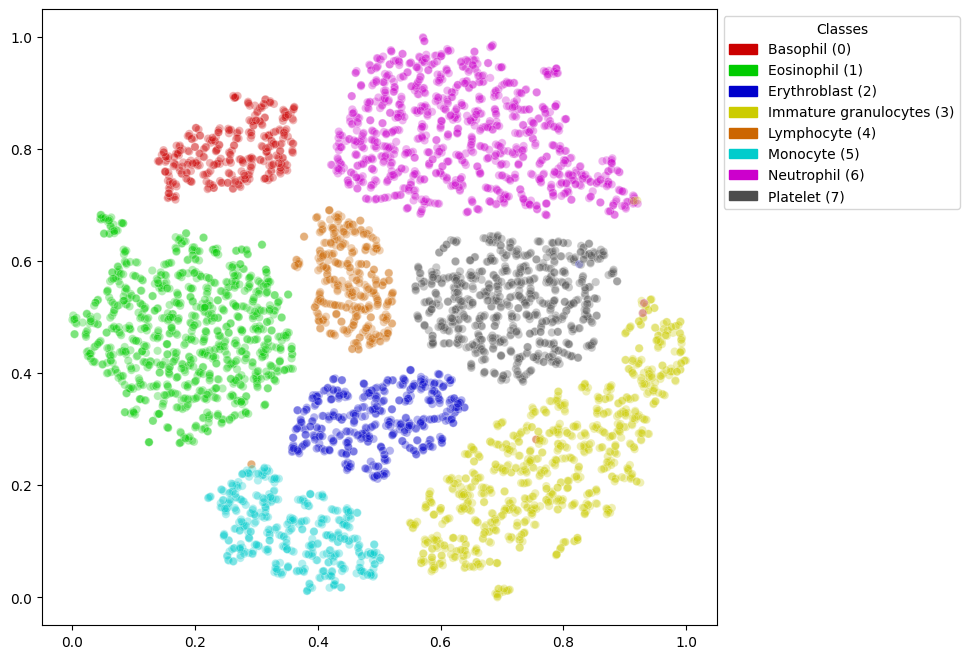

In [23]:
num_classes = 8

colors = list(label_color_dict.values())

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=y_tsne, palette=colors, alpha=0.3, legend=None)

legend_labels = [Patch(color=label_color_dict[i], label=f"{label_enc_dict[i]} ({i})") for i in range(num_classes)]
plt.legend(handles=legend_labels, loc='upper left', fontsize=10, title="Classes", bbox_to_anchor=(1.0, 1))

plt.subplots_adjust(right=0.8)
plt.grid(False)

plt.show()

### Images viz

Visualize embedded images in two dimensions:

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

def add_border(image, color, border_width=5):
    img_height, img_width = image.shape[:2]
    bordered_img = np.ones((img_height + 2 * border_width, img_width + 2 * border_width, 3), dtype=np.float32)  # White background
    bordered_img[border_width:img_height + border_width, border_width:img_width + border_width] = image
    bordered_img[:border_width, :, :] = color  # Top border
    bordered_img[-border_width:, :, :] = color  # Bottom border
    bordered_img[:, :border_width, :] = color  # Left border
    bordered_img[:, -border_width:, :] = color  # Right border
    return bordered_img

def plot_tsne_grid(embeddings, images, labels, label_encoding_dict, label_color_dict, grid_size=(10, 10), image_size=(32, 32), border_width=2):
    # Generate grid points
    x_lin = np.linspace(0, 1, grid_size[1])  # Horizontal grid points
    y_lin = np.linspace(0, 1, grid_size[0])  # Vertical grid points
    grid_points = np.array([[x, y] for y in y_lin for x in x_lin])

    # Assign embeddings to nearest grid points
    tree = cKDTree(grid_points)
    _, indices = tree.query(embeddings)

    # Define a set of distinct colors for the borders (one for each class)
    num_classes = len(label_encoding_dict)

    # Create blank canvas for the grid (RGB canvas)
    canvas_height = grid_size[0] * (image_size[0] + 2 * border_width)
    canvas_width = grid_size[1] * (image_size[1] + 2 * border_width)
    canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.float32)  # White background (1s for RGB)

    # Place images on the canvas with borders
    for i, img in enumerate(images):
        grid_idx = indices[i]
        gx, gy = divmod(grid_idx, grid_size[1])  # Convert flat index to 2D grid index
        x_start, y_start = gx * (image_size[0] + 2 * border_width), gy * (image_size[1] + 2 * border_width)

        # Resize image if needed (Ensure it is a float32 tensor)
        resized_img = tf.image.resize(img, image_size).numpy().astype(np.float32)

        # Add a border around the image based on its class label
        label_idx = labels[i]
        border_color = label_color_dict[label_idx]  # Get the RGB color for the label
        bordered_img = add_border(resized_img, border_color, border_width)

        # Place the bordered image on the canvas
        canvas[x_start:x_start + bordered_img.shape[0], y_start:y_start + bordered_img.shape[1]] = bordered_img

    # Create a Seaborn-style plot with the images and borders
    plt.figure(figsize=(12, 12))
    plt.imshow(canvas)
    plt.axis('off')

    # Create legend for the class colors
    legend_labels = [Patch(color=label_color_dict[i], label=f"{label_encoding_dict[i]} ({i})") for i in range(num_classes)]
    plt.legend(handles=legend_labels, loc='upper left', fontsize=10, title="Classes", bbox_to_anchor=(1.0, 1))

    # Adjust space for the right margin and plot layout
    plt.subplots_adjust(right=0.8)

    # Display the plot
    plt.show()

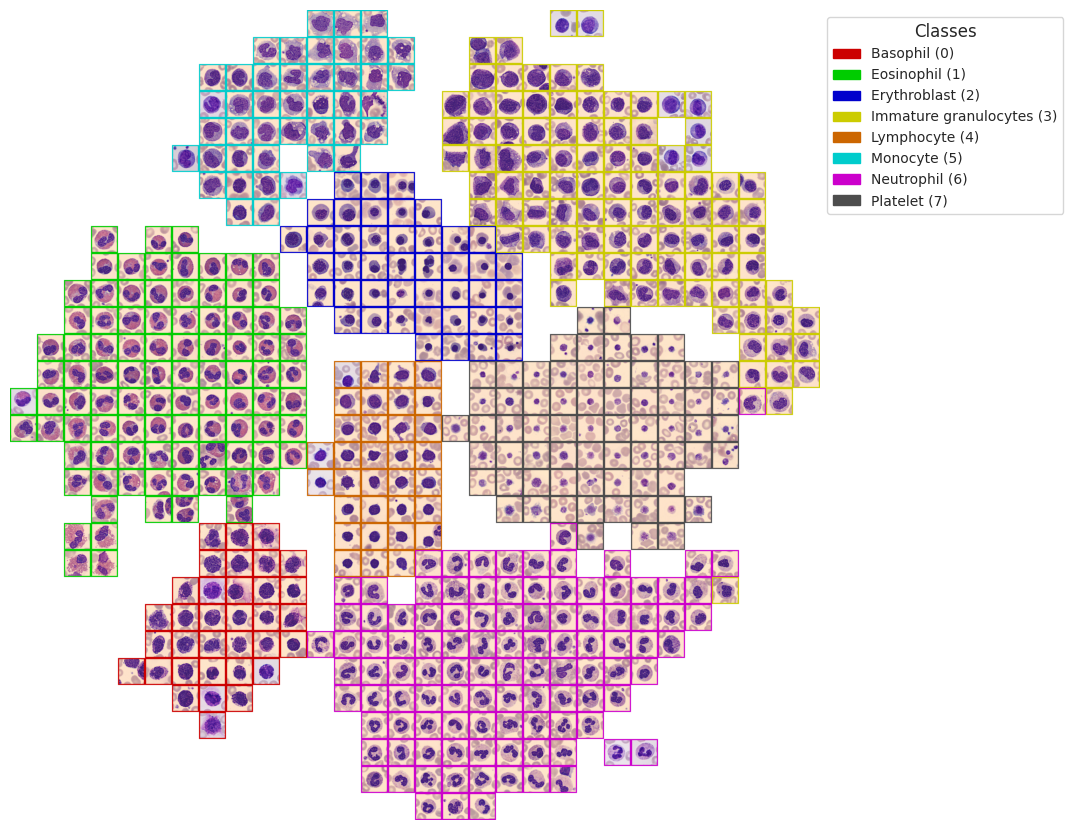

In [ ]:
plot_tsne_grid(embeddings, X_tsne, y_tsne, label_enc_dict, label_color_dict,
               grid_size=(30, 30), image_size=(64, 64), border_width=3)

# Grad-CAM

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
X_gradcam = tf.image.resize(images[4:5]/255., (224, 224)).numpy().astype(np.float32)

# Remove last layer's softmax
MODEL.layers[-1].activation = None

# Print what the top predicted class is
preds = MODEL.predict(X_gradcam)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(X_gradcam, MODEL, "convnext_xlarge_stage_3_block_1_pointwise_conv_2")

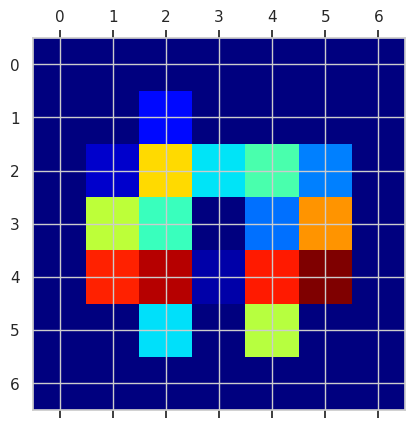

In [ ]:
# Display heatmap
plt.matshow(heatmap, cmap="jet")
plt.show()

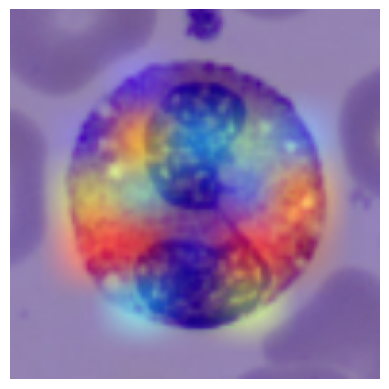

In [ ]:
def save_and_display_gradcam(images, heatmap, alpha=0.8):
    # Load the original image
    img = images[0]

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)/255.

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

from IPython.display import Image, display

save_and_display_gradcam(X_gradcam, heatmap)

# SVM

In [ ]:
features_MODEL = tfk.Model(
    inputs  = MODEL.input,
    outputs = MODEL.get_layer("layer_normalization_1").output)

In [ ]:
def predict(model, X, batch_size=1024):
    num_samples = len(X)
    preds = []

    # Process input data in batches
    for i in range(0, num_samples, batch_size):
        batch = X[i:i + batch_size]

        # Resize and normalize the batch
        batch_resized = tf.image.resize(batch, [224, 224])
        batch_normalized = batch_resized / 255.0

        # Convert to tensor
        batch_tensor = tf.convert_to_tensor(batch_normalized, dtype=tf.float32)

        # Make predictions on the batch
        batch_preds = model.predict(batch_tensor, batch_size=batch_size,
                                    verbose=1)

        # Append predictions to the list
        preds.extend(batch_preds)

    return np.array(preds)

In [ ]:
features = predict(features_MODEL, images[:500])
y = labels[:500]
features.shape, y_tsne.shape

((11951, 2048), (11951,))

In [ ]:
# prompt: Use a SVM to classify features vector

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Assuming 'features' and 'y_tsne' are defined from the previous code
X_train, X_test, y_train, y_test = train_test_split(features, y_tsne, test_size=0.2, random_state=SEED)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1, random_state=SEED)  # You can adjust kernel and C
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9974905897114178
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       449
           2       1.00      1.00      1.00       215
           3       0.99      0.99      0.99       393
           4       1.00      0.99      1.00       164
           5       0.99      1.00      1.00       193
           6       1.00      1.00      1.00       480
           7       1.00      1.00      1.00       315

    accuracy                           1.00      2391
   macro avg       1.00      1.00      1.00      2391
weighted avg       1.00      1.00      1.00      2391



In [ ]:
def predict_batch(X, batch_size=64):
    # Process input data in batches
    y = np.array([])
    num_samples = len(X)
    for i in range(0, num_samples, batch_size):
        batch = (X[i:i + batch_size]/255.).astype(np.float32)

        batch = tf.image.resize(batch, [224, 224])
        batch = tf.convert_to_tensor(batch, dtype=tf.float32).numpy()
        y = np.append(y, batch)

    return y